In [ ]:
!pip install d2l

In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

# **5.1. Multilayer Perceptrons**
## **5.1.1. Hidden layer**
### **5.1.1.1. Limitations of Linear Models**
If we were trying to predict whether an individual will repay a loan, we might reasonably assume that all other things being equal, an applicant with a higher income would always be more likely to repay than one with a lower income. While monotonic, this relationship likely is not linearly associated with the probability of repayment. An increase in income from $0 to $50,000 likely corresponds to a bigger increase in likelihood of repayment than an increase from \$1 million to \$1.05 million. One way to handle this might be to postprocess our outcome such that linearity becomes more plausible, by using the logistic map (and thus the logarithm of the probability of outcome).

Note that we can easily come up with examples that violate monotonicity. Say for example that we want to predict health as a function of body temperature. For individuals with a normal body temperature above 37°C (98.6°F), higher temperatures indicate greater risk. However, if the body temperatures drops below 37°C, lower temperatures indicate greater risk! Again, we might resolve the problem with some clever preprocessing, such as using the distance from 37°C as a feature.

But what about classifying images of cats and dogs? Should increasing the intensity of the pixel at location (13, 17) always increase (or always decrease) the likelihood that the image depicts a dog? Reliance on a linear model corresponds to the implicit assumption that the only requirement for differentiating cats and dogs is to assess the brightness of individual pixels. This approach is doomed to fail in a world where inverting an image preserves the category.

And yet despite the apparent absurdity of linearity here, as compared with our previous examples, it is less obvious that we could address the problem with a simple preprocessing fix. That is, because the significance of any pixel depends in complex ways on its context (the values of the surrounding pixels). While there might exist a representation of our data that would take into account the relevant interactions among our features, on top of which a linear model would be suitable, we simply do not know how to calculate it by hand. With deep neural networks, we used observational data to jointly learn both a representation via hidden layers and a linear predictor that acts upon that representation.



*This is an example of using linear model on interleaving dataset*

In [ ]:
import torch, torch.nn as nn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Make a non-linear dataset (two interleaving moons)
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Simple linear soft-max model
model_lin = nn.Sequential(nn.Linear(2, 2))
loss_fn  = nn.CrossEntropyLoss()
optim    = torch.optim.SGD(model_lin.parameters(), lr=0.1)

# 3. Train
for epoch in range(300):
    optim.zero_grad()
    loss = loss_fn(model_lin(X), y)
    loss.backward(); optim.step()

print("Linear model training accuracy:",
      (model_lin(X).argmax(1) == y).float().mean().item())


Linear model training accuracy: 0.8579999804496765


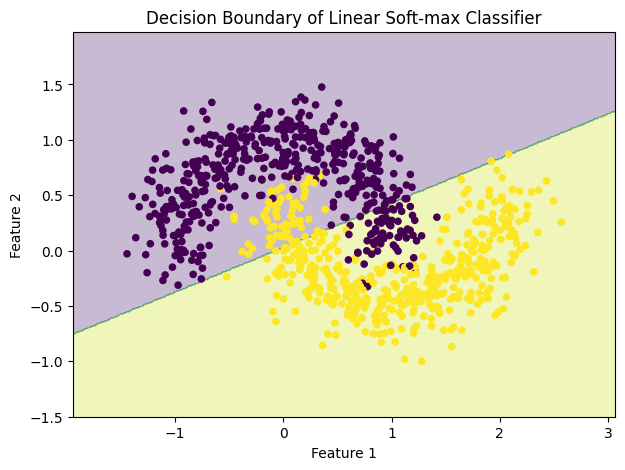

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

# predict over the whole grid
with torch.no_grad():
    Z = model_lin(grid).argmax(1).view(xx.shape).cpu().numpy()

# plot decision regions + data points
plt.figure(figsize=(7, 5))
plt.contourf(xx, yy, Z, alpha=0.3)         # decision regions
plt.scatter(X[:, 0], X[:, 1], c=y, s=20)   # data
plt.title("Decision Boundary of Linear Soft-max Classifier")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


*Using MLP with one hidden layer*

In [ ]:
model_mlp = nn.Sequential(
    nn.Linear(2, 16), nn.ReLU(),
    nn.Linear(16, 2)
)
optim = torch.optim.SGD(model_mlp.parameters(), lr=0.1)
for epoch in range(1000):
    optim.zero_grad()
    loss = loss_fn(model_mlp(X), y)
    loss.backward(); optim.step()

print("MLP training accuracy:",
      (model_mlp(X).argmax(1) == y).float().mean().item())

MLP training accuracy: 0.902999997138977


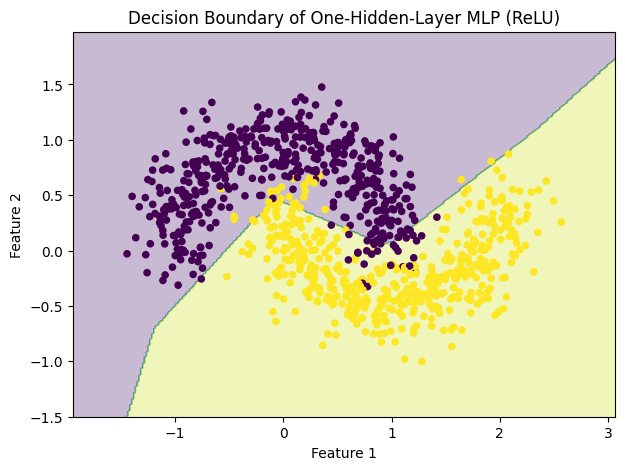

In [ ]:
# Plot the result
import numpy as np
from matplotlib import pyplot as plt
import torch

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

with torch.no_grad():
    Z = model_mlp(grid).argmax(1).view(xx.shape).cpu().numpy()


plt.figure(figsize=(7, 5))
plt.contourf(xx, yy, Z, alpha=0.3)         # coloured regions
plt.scatter(X[:, 0], X[:, 1], c=y, s=20)   # data points
plt.title("Decision Boundary of One-Hidden-Layer MLP (ReLU)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

### **5.1.1.2. Incorporating Hidden Layers**
We can overcome the limitations of linear models
by incorporating one or more hidden layers.
The easiest way to do this is to stack
many fully connected layers on top of one another.
Each layer feeds into the layer above it,
until we generate outputs.
We can think of the first $L-1$ layers
as our representation and the final layer
as our linear predictor.
This architecture is commonly called
a *multilayer perceptron*,
often abbreviated as *MLP* (:numref:`fig_mlp`).

![An MLP with a hidden layer of five hidden units.](http://d2l.ai/_images/mlp.svg)

:label:`fig_mlp`

This MLP has four inputs, three outputs,
and its hidden layer contains five hidden units.
Since the input layer does not involve any calculations,
producing outputs with this network
requires implementing the computations
for both the hidden and output layers;
thus, the number of layers in this MLP is two.
Note that both layers are fully connected.
Every input influences every neuron in the hidden layer,
and each of these in turn influences
every neuron in the output layer. Alas, we are not quite
done yet.


### **5.1.1.3. From Linear to Nonlinear**

*Terminologies:*


**Affine function:** Linear function plus a bias. f(x) = Wx + b
Where

- **x** ∈ ℝⁿ: the input vector  
- **W** ∈ ℝᵐˣⁿ: a matrix of weights  
- **b** ∈ ℝᵐ: a bias (offset) vector




As before, we denote by the matrix $\mathbf{X} \in \mathbb{R}^{n \times d}$
a minibatch of $n$ examples where each example has $d$ inputs (features).
For a one-hidden-layer MLP whose hidden layer has $h$ hidden units,
we denote by $\mathbf{H} \in \mathbb{R}^{n \times h}$
the outputs of the hidden layer, which are
*hidden representations*.
Since the hidden and output layers are both fully connected,
we have hidden-layer weights $\mathbf{W}^{(1)} \in \mathbb{R}^{d \times h}$ and biases $\mathbf{b}^{(1)} \in \mathbb{R}^{1 \times h}$
and output-layer weights $\mathbf{W}^{(2)} \in \mathbb{R}^{h \times q}$ and biases $\mathbf{b}^{(2)} \in \mathbb{R}^{1 \times q}$.
This allows us to calculate the outputs $\mathbf{O} \in \mathbb{R}^{n \times q}$
of the one-hidden-layer MLP as follows:

$$
\begin{aligned}
    \mathbf{H} & = \mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}, \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.
\end{aligned}
$$

Note that after adding the hidden layer,
our model now requires us to track and update
additional sets of parameters.
So what have we gained in exchange?
You might be surprised to find out
that---in the model defined above---*we
gain nothing for our troubles*!
The reason is plain.
The hidden units above are given by
an affine function of the inputs,
and the outputs (pre-softmax) are just
an affine function of the hidden units.
An affine function of an affine function
is itself an affine function.
Moreover, our linear model was already
capable of representing any affine function.

To see this formally we can just collapse out the hidden layer in the above definition,
yielding an equivalent single-layer model with parameters
$\mathbf{W} = \mathbf{W}^{(1)}\mathbf{W}^{(2)}$ and $\mathbf{b} = \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)}$:

$$
\mathbf{O} = (\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})\mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W}^{(1)}\mathbf{W}^{(2)} + \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W} + \mathbf{b}.
$$

In order to realize the potential of multilayer architectures,
we need one more key ingredient: a
nonlinear *activation function* $\sigma$
to be applied to each hidden unit
following the affine transformation. For instance, a popular
choice is the ReLU (rectified linear unit) activation function :cite:`Nair.Hinton.2010`
$\sigma(x) = \mathrm{max}(0, x)$ operating on its arguments elementwise.
The outputs of activation functions $\sigma(\cdot)$
are called *activations*.
In general, with activation functions in place,
it is no longer possible to collapse our MLP into a linear model:

$$
\begin{aligned}
    \mathbf{H} & = \sigma(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}), \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.\\
\end{aligned}
$$

Since each row in $\mathbf{X}$ corresponds to an example in the minibatch,
with some abuse of notation, we define the nonlinearity
$\sigma$ to apply to its inputs in a rowwise fashion,
i.e., one example at a time.
Note that we used the same notation for softmax
when we denoted a rowwise operation in :numref:`subsec_softmax_vectorization`.
Quite frequently the activation functions we use apply not merely rowwise but
elementwise. That means that after computing the linear portion of the layer,
we can calculate each activation
without looking at the values taken by the other hidden units.

To build more general MLPs, we can continue stacking
such hidden layers,
e.g., $\mathbf{H}^{(1)} = \sigma_1(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})$
and $\mathbf{H}^{(2)} = \sigma_2(\mathbf{H}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)})$,
one atop another, yielding ever more expressive models.

## **5.1.2. Activation Function**
Activation functions decide whether a neuron should be activated or not by calculating the weighted sum and further adding bias to it. They are differentiable operators for transforming input signals to outputs, while most of them add nonlinearity. Because activation functions are fundamental to deep learning, let’s briefly survey some common ones.

### **5.1.2.1. ReLU Function**
The most popular choice,
due to both simplicity of implementation and
its good performance on a variety of predictive tasks,
is the *rectified linear unit* (*ReLU*) :cite:`Nair.Hinton.2010`.
[**ReLU provides a very simple nonlinear transformation**].
Given an element $x$, the function is defined
as the maximum of that element and $0$:

$$\operatorname{ReLU}(x) = \max(x, 0).$$

Informally, the ReLU function retains only positive
elements and discards all negative elements
by setting the corresponding activations to 0.
To gain some intuition, we can plot the function.
As you can see, the activation function is piecewise linear.The most popular choice,
due to both simplicity of implementation and
its good performance on a variety of predictive tasks,
is the *rectified linear unit* (*ReLU*) :cite:`Nair.Hinton.2010`.
[**ReLU provides a very simple nonlinear transformation**].
Given an element $x$, the function is defined
as the maximum of that element and $0$:

$$\operatorname{ReLU}(x) = \max(x, 0).$$

Informally, the ReLU function retains only positive
elements and discards all negative elements
by setting the corresponding activations to 0.
To gain some intuition, we can plot the function.
As you can see, the activation function is piecewise linear.

When the input is negative, the derivative of the ReLU function is 0, and when the input is positive, the derivative of the ReLU function is 1. Note that the ReLU function is not differentiable when the input takes value precisely equal to 0. In these cases, we default to the left-hand-side derivative and say that the derivative is 0 when the input is 0. We can get away with this because the input may never actually be zero (mathematicians would say that it is nondifferentiable on a set of measure zero). There is an old adage that if subtle boundary conditions matter, we are probably doing (real) mathematics, not engineering. That conventional wisdom may apply here, or at least, the fact that we are not performing constrained optimization :cite:Mangasarian.1965,Rockafellar.1970. We plot the derivative of the ReLU function below.


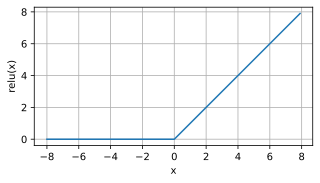

In [ ]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

The reason for using ReLU is that its derivatives are particularly well behaved: either they vanish or they just let the argument through. This makes optimization better behaved and it mitigated the well-documented problem of vanishing gradients that plagued previous versions of neural networks (more on this later).


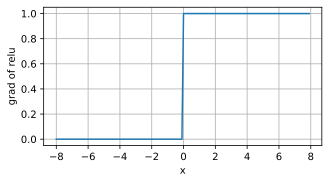

In [ ]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

$$\operatorname{pReLU}(x) = \max(0, x) + \alpha \min(0, x).$$


### **5.1.2.2. Sigmoid Function**
[**The *sigmoid function* transforms those inputs**]
whose values lie in the domain $\mathbb{R}$,
(**to outputs that lie on the interval (0, 1).**)
For that reason, the sigmoid is
often called a *squashing function*:
it squashes any input in the range (-inf, inf)
to some value in the range (0, 1):

$$\operatorname{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.$$

In the earliest neural networks, scientists
were interested in modeling biological neurons
that either *fire* or *do not fire*.
Thus the pioneers of this field,
going all the way back to McCulloch and Pitts,
the inventors of the artificial neuron,
focused on thresholding units :cite:`McCulloch.Pitts.1943`.
A thresholding activation takes value 0
when its input is below some threshold
and value 1 when the input exceeds the threshold.

When attention shifted to gradient-based learning,
the sigmoid function was a natural choice
because it is a smooth, differentiable
approximation to a thresholding unit.
Sigmoids are still widely used as
activation functions on the output units
when we want to interpret the outputs as probabilities
for binary classification problems: you can think of the sigmoid as a special case of the softmax.
However, the sigmoid has largely been replaced
by the simpler and more easily trainable ReLU
for most use in hidden layers. Much of this has to do
with the fact that the sigmoid poses challenges for optimization
:cite:`LeCun.Bottou.Orr.ea.1998` since its gradient vanishes for large positive *and* negative arguments.
This can lead to plateaus that are difficult to escape from.
Nonetheless sigmoids are important. In later chapters (e.g., :numref:`sec_lstm`) on recurrent neural networks,
we will describe architectures that leverage sigmoid units
to control the flow of information across time.

Below, we plot the sigmoid function.
Note that when the input is close to 0,
the sigmoid function approaches
a linear transformation.


In [ ]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

The derivative of the sigmoid function is given by the following equation:

$$\frac{d}{dx} \operatorname{sigmoid}(x) = \frac{\exp(-x)}{(1 + \exp(-x))^2} = \operatorname{sigmoid}(x)\left(1-\operatorname{sigmoid}(x)\right).$$


The derivative of the sigmoid function is plotted below.
Note that when the input is 0,
the derivative of the sigmoid function
reaches a maximum of 0.25.
As the input diverges from 0 in either direction,
the derivative approaches 0.

In [ ]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

### **5.1.2.3. Tanh Function**
:label:`subsec_tanh`

Like the sigmoid function, [**the tanh (hyperbolic tangent)
function also squashes its inputs**],
transforming them into elements on the interval (**between $-1$ and $1$**):

$$\operatorname{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.$$

We plot the tanh function below. Note that as input nears 0, the tanh function approaches a linear transformation. Although the shape of the function is similar to that of the sigmoid function, the tanh function exhibits point symmetry about the origin of the coordinate system :cite:`Kalman.Kwasny.1992`.



In [ ]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

In [ ]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

The derivative of the tanh function is:

$$\frac{d}{dx} \operatorname{tanh}(x) = 1 - \operatorname{tanh}^2(x).$$

It is plotted below.
As the input nears 0,
the derivative of the tanh function approaches a maximum of 1.
And as we saw with the sigmoid function,
as input moves away from 0 in either direction,
the derivative of the tanh function approaches 0.

## **5.1.3. Summary and Discussion**


We now know how to incorporate nonlinearities
to build expressive multilayer neural network architectures.
As a side note, your knowledge already
puts you in command of a similar toolkit
to a practitioner circa 1990.
In some ways, you have an advantage
over anyone working back then,
because you can leverage powerful
open-source deep learning frameworks
to build models rapidly, using only a few lines of code.
Previously, training these networks
required researchers to code up layers and derivatives
explicitly in C, Fortran, or even Lisp (in the case of LeNet).

A secondary benefit is that ReLU is significantly more amenable to
optimization than the sigmoid or the tanh function. One could argue
that this was one of the key innovations that helped the resurgence
of deep learning over the past decade. Note, though, that research in
activation functions has not stopped.
For instance,
the GELU (Gaussian error linear unit)
activation function $x \Phi(x)$ by :citet:`Hendrycks.Gimpel.2016` ($\Phi(x)$
is the standard Gaussian cumulative distribution function)
and
the Swish activation
function $\sigma(x) = x \operatorname{sigmoid}(\beta x)$ as proposed in :citet:`Ramachandran.Zoph.Le.2017` can yield better accuracy
in many cases.

## Exercises

1. Show that adding layers to a *linear* deep network, i.e., a network without
   nonlinearity $\sigma$ can never increase the expressive power of the network.
   Give an example where it actively reduces it.
1. Compute the derivative of the pReLU activation function.
1. Compute the derivative of the Swish activation function $x \operatorname{sigmoid}(\beta x)$.
1. Show that an MLP using only ReLU (or pReLU) constructs a
   continuous piecewise linear function.
1. Sigmoid and tanh are very similar.
    1. Show that $\operatorname{tanh}(x) + 1 = 2 \operatorname{sigmoid}(2x)$.
    1. Prove that the function classes parametrized by both nonlinearities are identical. Hint: affine layers have bias terms, too.
1. Assume that we have a nonlinearity that applies to one minibatch at a time, such as the batch normalization :cite:`Ioffe.Szegedy.2015`. What kinds of problems do you expect this to cause?
1. Provide an example where the gradients vanish for the sigmoid activation function.

#### **Ex1: Show that adding layers to a linear deep network, i.e., a network without nonlinearity  σ  can never increase the expressive power of the network. Give an example where it actively reduces it.**

**Terminology**:

Model expressiveness (also known as expressive power) refers to a model’s ability to represent a wide variety of functions or mappings from input to output. In simple terms, it tells us how complex the functions are that a model can learn or approximate.

Higher expressiveness means the model can represent more complex patterns

Lower expressiveness means the model is limited to simpler functions

Explain:

A deep linear network is a composition of linear functions.

A **linear transformation** has the form:

$$
f(\mathbf{x}) = \mathbf{W} \mathbf{x} + \mathbf{b}
$$

If we stack multiple linear layers like this:

$$
f(\mathbf{x}) = \mathbf{W}_3(\mathbf{W}_2(\mathbf{W}_1\mathbf{x}))
$$

It simplifies to:

$$
f(\mathbf{x}) = (\mathbf{W}_3 \cdot \mathbf{W}_2 \cdot \mathbf{W}_1)\mathbf{x}
$$

Which is still a **single linear transformation**.

**Therefore**, adding more linear layers without nonlinear activation functions **does not increase** the model’s expressiveness.

$$
\text{rank}(AB) \leq \min\left(\text{rank}(A), \text{rank}(B)\right)
$$

By the properties of Rank: (check https://en.wikipedia.org/wiki/Rank_(linear_algebra) )


## Mathematical Proof

Let:

$$ \mathbf{W}_1 \in \mathbb{R}^{k \times n} $$

$$ \mathbf{W}_2 \in \mathbb{R}^{m \times k} $$

Then:

$$
\mathbf{y} = \mathbf{W}_2(\mathbf{W}_1 \mathbf{x}) = (\mathbf{W}_2 \cdot \mathbf{W}_1) \mathbf{x}
$$

So the composition is still linear:

$$
\text{Linear} \circ \text{Linear} = \text{Linear}
$$


## Example Where It Reduces Expressiveness

Suppose you insert a narrow layer in between:

$$\mathbf{W}_1 \in \mathbb{R}^{2 \times 3}$$
$$\mathbf{W}_2 \in \mathbb{R}^{1 \times 2}$$

Then:

$$
\mathbf{W} = \mathbf{W}_2 \cdot \mathbf{W}_1 \in \mathbb{R}^{1 \times 3}
$$


Therefore, the **rank of $ \mathbf{W} $** is at most **1**, which restricts the function to a very limited class of mappings. You lose expressiveness compared to a full-rank $ 1 \times 3 $ matrix.


### Ex2: Compute the derivative of the pReLU activation function.

pReLU (Parameterized ReLU) activation function:


$$
f(x) =
\begin{cases}
x & \text{if } x > 0 \\
a x & \text{if } x \leq 0
\end{cases}
$$

Derivative of pRelu

$$
f'(x) =
\begin{cases}
1 & \text{if } x > 0 \\
a & \text{if } x \leq 0
\end{cases}
$$

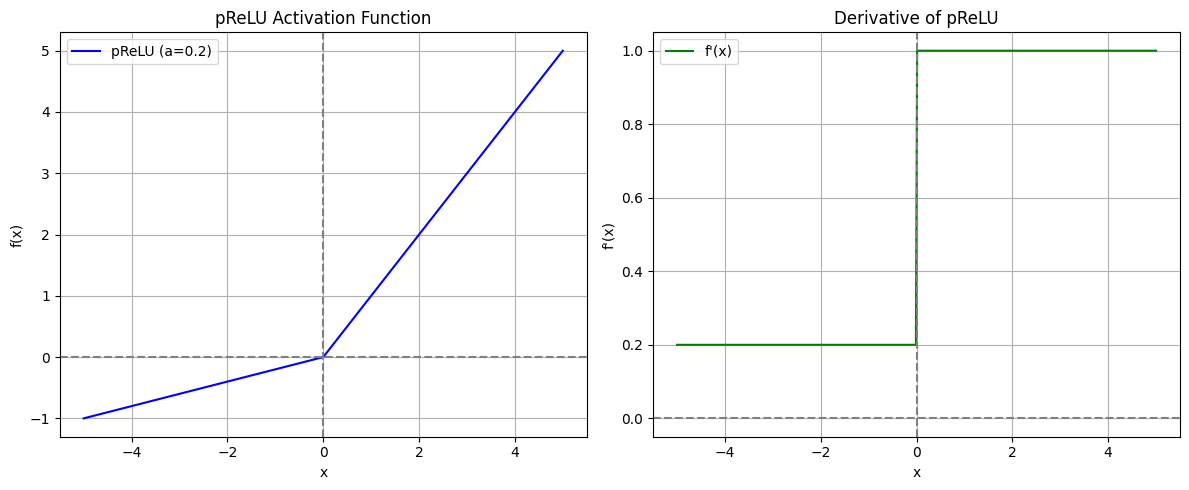

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# pReLU function and derivative
def prelu(x, a=0.2):
    return np.where(x > 0, x, a * x)

def prelu_derivative(x, a=0.2):
    return np.where(x > 0, 1, a)

# Input values
x_vals = np.linspace(-5, 5, 400)
y_vals = prelu(x_vals)
dy_vals = prelu_derivative(x_vals)

# Plot
plt.figure(figsize=(12, 5))

# Plot pReLU
plt.subplot(1, 2, 1)
plt.plot(x_vals, y_vals, label='pReLU (a=0.2)', color='blue')
plt.title('pReLU Activation Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.legend()

# Plot derivative
plt.subplot(1, 2, 2)
plt.plot(x_vals, dy_vals, label="f'(x)", color='green')
plt.title("Derivative of pReLU")
plt.xlabel('x')
plt.ylabel("f'(x)")
plt.grid(True)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.legend()

plt.tight_layout()
plt.show()

## Ex3. Derivative of Swish Activation Function

Swish is defined as:

$$
f(x) = x \cdot \sigma(\beta x)
\quad \text{where } \sigma(z) = \frac{1}{1 + e^{-z}}
$$

Let:

- $s(x) = \sigma(\beta x)$
- $f(x) = x \cdot s(x)$


We want to compute:

$$
f'(x) = \frac{d}{dx} \left( x \cdot s(x) \right)
$$

Using the **product rule**:

$$
f'(x) = \frac{d}{dx}[x] \cdot s(x) + x \cdot \frac{d}{dx}[s(x)]
$$

$$
f'(x) = 1 \cdot s(x) + x \cdot s'(x)
$$

Now compute $ s'(x) $ where $ s(x) = \sigma(\beta x) $:

$$
\sigma'(z) = \sigma(z)(1 - \sigma(z))
$$

So:

$$
s'(x) = \frac{d}{dx}[\sigma(\beta x)] = \beta \cdot \sigma(\beta x)(1 - \sigma(\beta x))
$$

Substitute $ s(x) = \sigma(\beta x) $ and $ s'(x) $

$$
f'(x) = \sigma(\beta x) + x \cdot \beta \cdot \sigma(\beta x) (1 - \sigma(\beta x))
$$

THen

$$
f'(x) = \sigma(\beta x) \left[1 + \beta x (1 - \sigma(\beta x)) \right]
$$


x: [-1.0, 0.0, 1.0]
Swish output: [-0.2689414322376251, 0.0, 0.7310585975646973]
Swish derivative (autograd): [0.07232949137687683, 0.5, 0.9276705384254456]


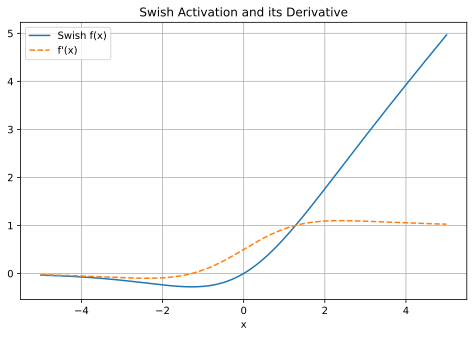

In [ ]:
import torch
import torch.nn.functional as F

x = torch.tensor([[-1.0], [0.0], [1.0]], requires_grad=True)
beta = 1.0

# Swish activation
swish = x * torch.sigmoid(beta * x)
swish.backward(torch.ones_like(x))

print("x:", x.ravel().tolist())
print("Swish output:", swish.ravel().tolist())
print("Swish derivative (autograd):", x.grad.ravel().tolist())

# Input range
x = torch.linspace(-5, 5, 200, requires_grad=True)
beta = 1.0

# Swish function: f(x) = x * sigmoid(beta * x)
sigmoid = torch.sigmoid(beta * x)
swish = x * sigmoid

# Compute derivative via autograd
swish.sum().backward()
swish_grad = x.grad.detach()

# Plot Swish and its derivative
plt.figure(figsize=(8, 5))
plt.plot(x.detach(), swish.detach(), label='Swish f(x)')
plt.plot(x.detach(), swish_grad, label="f'(x)", linestyle='--')
plt.title('Swish Activation and its Derivative')
plt.xlabel('x')
plt.legend()
plt.grid(True)
plt.show()

## Ex4. Why an MLP with ReLU (or PReLU) Is a Continuous Piecewise Linear Function

Terminologies:
Piecewise Linear Function: a function that is made up of multiple linear pieces, each defined on a specific interval of the input space.

f(x) is a piecewise linear function if:

The domain is divided into segments
on each segment, f(x) is a linear function


###  Activation Function: ReLU / PReLU

ReLU:
$$
\text{ReLU}(x) = \max(0, x)
$$

PReLU:
$$
\text{PReLU}(x) = \begin{cases}
x & \text{if } x > 0 \\
\alpha x & \text{if } x \leq 0
\end{cases}
$$

- Both are **continuous**
- Both are **piecewise linear** functions





### Composition of Piecewise Linear Functions

Composition of linear and piecewise linear is still piecewise linear
When you apply:

Linear layer → ReLU → Linear → ReLU → ...
each layer transforms linear regions into other linear regions, but boundaries change due to the ReLU (or PReLU).

The result is a continuous function, because both affine transforms and ReLU/PReLU are continuous.

It is piecewise linear because within each activation pattern (which ReLUs are on/off), the entire network behaves like a linear function.

###  Final Conclusion

> An MLP using only ReLU or PReLU **always computes a continuous piecewise linear function**.





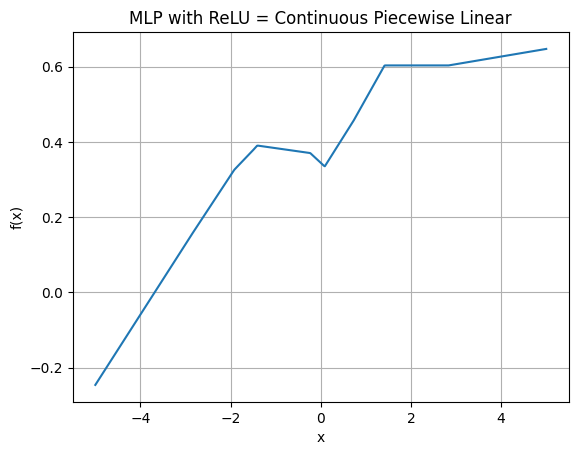

Text(0, 0.5, 'f(x)')

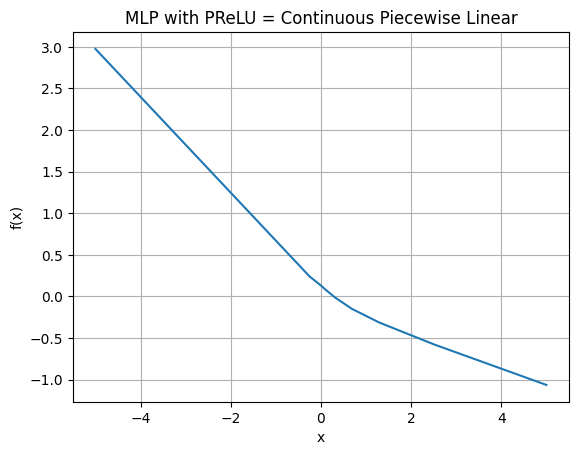

In [8]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

x = torch.linspace(-5, 5, 500).unsqueeze(1)

# Simple 2-layer MLP with ReLU
model = nn.Sequential(
    nn.Linear(1, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)

with torch.no_grad():
    y = model(x)

plt.plot(x.squeeze(), y.squeeze())
plt.title("MLP with ReLU = Continuous Piecewise Linear")
plt.grid(True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

model_prelu = nn.Sequential(
    nn.Linear(1,10),
    nn.PReLU(),
    nn.Linear(10,1)
)

with torch.no_grad():
    y = model_prelu(x)

plt.plot(x.squeeze(), y.squeeze())
plt.title("MLP with PReLU = Continuous Piecewise Linear")
plt.grid(True)
plt.xlabel("x")
plt.ylabel("f(x)")


## Ex.5 Tanh and Sigmoid Equivalence in MLPs

### Identity:

$$
\tanh(x) + 1 = 2 \cdot \sigma(2x)
$$

Proof:

$$
\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} \quad \Rightarrow \quad \tanh(x) + 1 = \frac{2e^x}{e^x + e^{-x}} = 2 \cdot \frac{1}{1 + e^{-2x}} = 2 \cdot \sigma(2x)
$$


### Functional Equivalence in MLPs

The output of a tanh unit can be written in terms of a sigmoid:

$$
\tanh(x) = 2\sigma(2x) - 1
\quad \text{and} \quad
\sigma(x) = \frac{\tanh(x/2) + 1}{2}
$$

These transformations are **affine**, and since MLPs already have affine layers (weights and biases), switching between tanh and sigmoid **does not change the space of functions an MLP can represent**.

**Conclusion**: MLPs using only tanh or only sigmoid span the **same class of functions**.


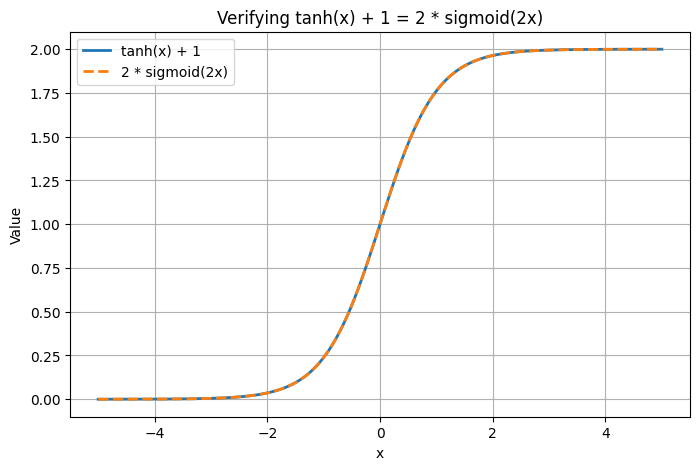

Max absolute difference between both sides: 2.38e-07


In [9]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Input range
x = torch.linspace(-5, 5, 500)

# Compute both sides of the identity
lhs = torch.tanh(x) + 1                      # LHS: tanh(x) + 1
rhs = 2 * torch.sigmoid(2 * x)               # RHS: 2 * sigmoid(2x)

# Plot the functions
plt.figure(figsize=(8, 5))
plt.plot(x, lhs, label='tanh(x) + 1', linewidth=2)
plt.plot(x, rhs, '--', label='2 * sigmoid(2x)', linewidth=2)
plt.title("Verifying tanh(x) + 1 = 2 * sigmoid(2x)")
plt.xlabel("x"); plt.ylabel("Value")
plt.grid(True); plt.legend()
plt.show()

# Maximum error to verify equality numerically
error = torch.max(torch.abs(lhs - rhs)).item()
print(f"Max absolute difference between both sides: {error:.2e}")


## Ex6. What Can Go Wrong with Batch-Level Nonlinearities (e.g., BatchNorm)?

BatchNorm applies normalization using the **statistics of a minibatch**, not individual samples.

### Potential Problems:

- **Inference mismatch**: During training, BN uses minibatch statistics; during inference, it uses running averages. This can lead to discrepancies in model behavior.

- **Small batch instability**: With small batches, estimated mean/variance are noisy ⇒ unstable training.

- **Loss of independence**: The output for one input depends on all others in the batch — breaking sample independence.

- **Multi-task / domain issues**: If batches mix different domains/tasks, normalization may remove important structure.


### Alternatives:
- **LayerNorm** – no batch dependence; great for transformers and RNNs.
- **InstanceNorm** – per-sample normalization.
- **GroupNorm** – compromise between BN and LN.


In [ ]:
import torch
import torch.nn as nn

# Define a simple MLP with BatchNorm
class SimpleBNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 4),
            nn.BatchNorm1d(4),  # <- batch-dependent nonlinearity
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)

# Create the model and set weights for consistent results
model = SimpleBNNet()
torch.manual_seed(42)
for m in model.modules():
    if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight, 1.0)
        nn.init.constant_(m.bias, 0.0)

# Create two identical inputs (will be processed in different batch contexts)
sample = torch.tensor([[1.0, 2.0, 3.0, 4.0]])
batch_with_noise = torch.cat([
    sample,
    torch.randn(7, 4) * 5  # add noisy samples
], dim=0)

# --- Run in training mode (uses batch stats)
model.train()
out_train = model(batch_with_noise)[0]  # first output corresponds to `sample`

# --- Run in eval mode (uses running stats)
model.eval()
out_eval = model(sample)

print("BatchNorm output in TRAIN mode (with other noisy samples):")
print(out_train)

print("\nBatchNorm output in EVAL mode (single input):")
print(out_eval.squeeze())


## Vanishing Gradient Problem with Sigmoid Activation

### Why does it happen?

The **sigmoid** function:

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

has a derivative:

$$
\sigma'(x) = \sigma(x)(1 - \sigma(x))
$$

- When \( x \gg 0 \) or \( x \ll 0 \), sigmoid saturates (approaches 1 or 0)
- Its derivative approaches **zero** in those regions
- This causes **gradients to vanish** as they backpropagate through deep layers


### Experiment

In the code below, we build a deep MLP with **sigmoid activations** and **large weights**, so most inputs fall in the saturated zone of sigmoid.

We then:
- Perform a forward and backward pass
- Measure the **gradient norm** across layers




Gradient norm of input: 0.002985934726893902


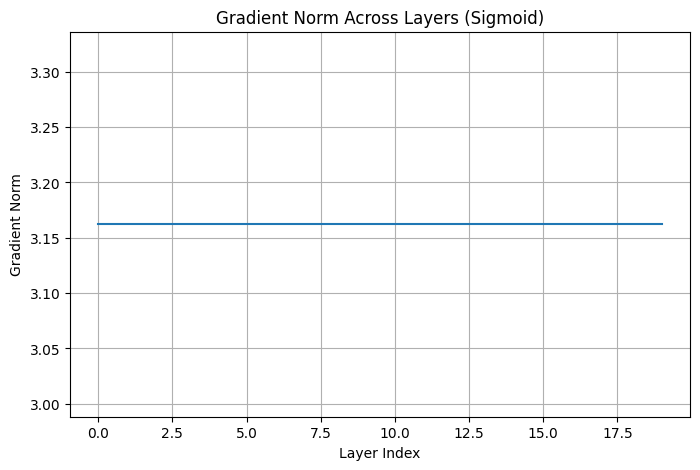

In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Build a deep network with sigmoid activations
class DeepSigmoidNet(nn.Module):
    def __init__(self, depth=20):
        super().__init__()
        layers = []
        for _ in range(depth):
            layers.append(nn.Linear(10, 10))
            layers.append(nn.Sigmoid())
        self.net = nn.Sequential(*layers)
        self.output = nn.Linear(10, 1)

    def forward(self, x):
        return self.output(self.net(x))

# Create model and initialize weights with high variance
model = DeepSigmoidNet()
for m in model.modules():
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=2.0)  # large weights

# Create input and forward pass
x = torch.randn(1, 10, requires_grad=True)
output = model(x)
output.backward()

# Inspect gradient of input and early layers
print("Gradient norm of input:", x.grad.norm().item())

# Plot gradients in intermediate layers
grads = []
x_temp = x.clone().detach().requires_grad_(True)
for i, layer in enumerate(model.net):
    x_temp = layer(x_temp)
    if isinstance(layer, nn.Linear):
        x_temp.retain_grad()
        x_temp.backward(torch.ones_like(x_temp), retain_graph=True)
        grads.append(x_temp.grad.norm().item())
        x_temp.grad = None  # clear for next iteration

# Plot
plt.figure(figsize=(8, 5))
plt.plot(grads)
plt.title("Gradient Norm Across Layers (Sigmoid)")
plt.xlabel("Layer Index")
plt.ylabel("Gradient Norm")
plt.grid(True)


# **5.2. Implement of Multilayer Perceptrons**

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

## Implementation from Scratch

Let's begin again by implementing such a network from scratch.

### Initializing Model Parameters

Recall that Fashion-MNIST contains 10 classes,
and that each image consists of a $28 \times 28 = 784$
grid of grayscale pixel values.
As before we will disregard the spatial structure
among the pixels for now,
so we can think of this as a classification dataset
with 784 input features and 10 classes.
To begin, we will [**implement an MLP
with one hidden layer and 256 hidden units.**]
Both the number of layers and their width are adjustable
(they are considered hyperparameters).
Typically, we choose the layer widths to be divisible by larger powers of 2.
This is computationally efficient due to the way
memory is allocated and addressed in hardware.

Again, we will represent our parameters with several tensors.
Note that *for every layer*, we must keep track of
one weight matrix and one bias vector.
As always, we allocate memory
for the gradients of the loss with respect to these parameters.

In the code below we use `nn.Parameter`
to automatically register
a class attribute as a parameter to be tracked by `autograd` (:numref:`sec_autograd`).


In [ ]:
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

### Model

To make sure we know how everything works,
we will [**implement the ReLU activation**] ourselves
rather than invoking the built-in `relu` function directly.

In [ ]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

Since we are disregarding spatial structure, we reshape each two-dimensional image into a flat vector of length num_inputs. Finally, we (implement our model) with just a few lines of code. Since we use the framework built-in autograd this is all that it takes.

In [ ]:
@d2l.add_to_class(MLPScratch)
def forward(self, X):
    X = X.reshape((-1, self.num_inputs))
    H = relu(torch.matmul(X, self.W1) + self.b1)
    return torch.matmul(H, self.W2) + self.b2

### Training

Fortunately, [**the training loop for MLPs
is exactly the same as for softmax regression.**] We define the model, data, and trainer, then finally invoke the `fit` method on model and data.


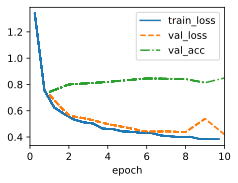

In [ ]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## Concise Implementation

As you might expect, by relying on the high-level APIs, we can implement MLPs even more concisely.

### Model

Compared with our concise implementation
of softmax regression implementation
(:numref:`sec_softmax_concise`),
the only difference is that we add
*two* fully connected layers where we previously added only *one*.
The first is [**the hidden layer**],
the second is the output layer.

In [ ]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))

Previously, we defined `forward` methods for models to transform input using the model parameters.
These operations are essentially a pipeline:
you take an input and
apply a transformation (e.g.,
matrix multiplication with weights followed by bias addition),
then repetitively use the output of the current transformation as
input to the next transformation.
However, you may have noticed that
no `forward` method is defined here.
In fact, `MLP` inherits the `forward` method from the `Module` class (:numref:`subsec_oo-design-models`) to
simply invoke `self.net(X)` (`X` is input),
which is now defined as a sequence of transformations
via the `Sequential` class.
The `Sequential` class abstracts the forward process
enabling us to focus on the transformations.
We will further discuss how the `Sequential` class works in :numref:`subsec_model-construction-sequential`.


### Training

[**The training loop**] is exactly the same
as when we implemented softmax regression.
This modularity enables us to separate
matters concerning the model architecture
from orthogonal considerations.

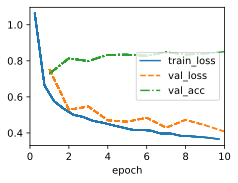

In [ ]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

## Summary

Now that we have more practice in designing deep networks, the step from a single to multiple layers of deep networks does not pose such a significant challenge any longer. In particular, we can reuse the training algorithm and data loader. Note, though, that implementing MLPs from scratch is nonetheless messy: naming and keeping track of the model parameters makes it difficult to extend models. For instance, imagine wanting to insert another layer between layers 42 and 43. This might now be layer 42b, unless we are willing to perform sequential renaming. Moreover, if we implement the network from scratch, it is much more difficult for the framework to perform meaningful performance optimizations.

Nonetheless, you have now reached the state of the art of the late 1980s when fully connected deep networks were the method of choice for neural network modeling. Our next conceptual step will be to consider images. Before we do so, we need to review a number of statistical basics and details on how to compute models efficiently.


## Exercises

1. Change the number of hidden units `num_hiddens` and plot how its number affects the accuracy of the model. What is the best value of this hyperparameter?
1. Try adding a hidden layer to see how it affects the results.
1. Why is it a bad idea to insert a hidden layer with a single neuron? What could go wrong?
1. How does changing the learning rate alter your results? With all other parameters fixed, which learning rate gives you the best results? How does this relate to the number of epochs?
1. Let's optimize over all hyperparameters jointly, i.e., learning rate, number of epochs, number of hidden layers, and number of hidden units per layer.
    1. What is the best result you can get by optimizing over all of them?
    1. Why it is much more challenging to deal with multiple hyperparameters?
    1. Describe an efficient strategy for optimizing over multiple parameters jointly.
1. Compare the speed of the framework and the from-scratch implementation for a challenging problem. How does it change with the complexity of the network?
1. Measure the speed of tensor--matrix multiplications for well-aligned and misaligned matrices. For instance, test for matrices with dimension 1024, 1025, 1026, 1028, and 1032.
    1. How does this change between GPUs and CPUs?
    1. Determine the memory bus width of your CPU and GPU.
1. Try out different activation functions. Which one works best?
1. Is there a difference between weight initializations of the network? Does it matter?


### Ex1. Change the number of hidden units num_hiddens

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

# Load dataset
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# Define training loop manually (since train_ch3 is not available)
def train(net, train_iter, test_iter, loss, num_epochs, updater):
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # Sum of training loss, correct preds, total examples
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), d2l.accuracy(y_hat, y), y.numel())
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        print(f"epoch {epoch + 1}, loss {metric[0] / metric[2]:.4f}, "
              f"train acc {metric[1] / metric[2]:.3f}, test acc {test_acc:.3f}")
    return test_acc

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Try different values of num_hiddens
num_hiddens_list = [16, 32, 64, 128]
test_accuracies = []

for num_hiddens in num_hiddens_list:
    # Define MLP model
    net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, num_hiddens),
        nn.ReLU(),
        nn.Linear(num_hiddens, 10)
    )
    net.to(device)

    # Initialize weights
    def init_weights(m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    # Define loss and optimizer
    loss = nn.CrossEntropyLoss()
    trainer = torch.optim.SGD(net.parameters(), lr=0.1)

    print(f"\nTraining with {num_hiddens} hidden units:")
    test_acc = train(net, train_iter, test_iter, loss, num_epochs=10, updater=trainer)
    test_accuracies.append(test_acc)

# Plot results
plt.plot(num_hiddens_list, test_accuracies, marker='o')
plt.title('Effect of num_hiddens on Test Accuracy')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()


ModuleNotFoundError: No module named 'd2l'

### Ex2. Try adding a hidden layer to see how it affects the results






Training with hidden layers: (16,)
epoch 1, loss 0.9448, train acc 0.669, test acc 0.706
epoch 2, loss 0.5989, train acc 0.785, test acc 0.772
epoch 3, loss 0.5392, train acc 0.811, test acc 0.791
epoch 4, loss 0.5037, train acc 0.825, test acc 0.822
epoch 5, loss 0.4874, train acc 0.831, test acc 0.771
epoch 6, loss 0.4714, train acc 0.835, test acc 0.829
epoch 7, loss 0.4641, train acc 0.838, test acc 0.796
epoch 8, loss 0.4490, train acc 0.844, test acc 0.832
epoch 9, loss 0.4385, train acc 0.846, test acc 0.834
epoch 10, loss 0.4313, train acc 0.850, test acc 0.837

Training with hidden layers: (16, 16)
epoch 1, loss 0.9042, train acc 0.680, test acc 0.745
epoch 2, loss 0.5593, train acc 0.802, test acc 0.794
epoch 3, loss 0.4953, train acc 0.825, test acc 0.789
epoch 4, loss 0.4721, train acc 0.833, test acc 0.815
epoch 5, loss 0.4513, train acc 0.840, test acc 0.833
epoch 6, loss 0.4331, train acc 0.847, test acc 0.837
epoch 7, loss 0.4183, train acc 0.850, test acc 0.787
epoch 

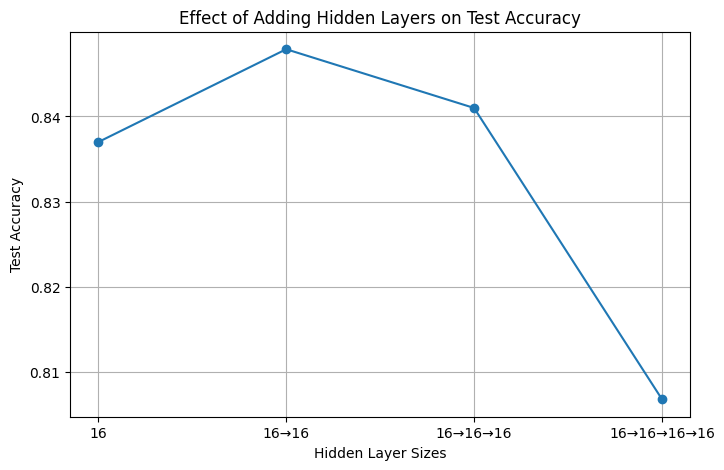

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

# Load data
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hidden layer configurations
hidden_layer_configs = [
    (16,),
    (16, 16),
    (16, 16, 16),
    (16, 16, 16, 16)
]

test_accuracies = []

# Custom evaluation to ensure .eval() and no_grad()
def evaluate_accuracy_gpu(net, data_iter):
    net.eval()
    metric = d2l.Accumulator(2)  # correct, total
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    net.train()
    return metric[0] / metric[1]

# Training loop
def train(net, train_iter, test_iter, loss, num_epochs, updater):
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # loss, correct, total
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), d2l.accuracy(y_hat, y), y.numel())
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        print(f"epoch {epoch + 1}, loss {metric[0] / metric[2]:.4f}, "
              f"train acc {metric[1] / metric[2]:.3f}, test acc {test_acc:.3f}")
    return test_acc

# Train models with different architectures
for config in hidden_layer_configs:
    print(f"\nTraining with hidden layers: {config}")

    layers = [nn.Flatten()]
    input_dim = 784
    for h in config:
        layers.append(nn.Linear(input_dim, h))
        layers.append(nn.ReLU())
        input_dim = h
    layers.append(nn.Linear(input_dim, 10))  # Output layer

    net = nn.Sequential(*layers).to(device)

    # Improved initialization
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    net.apply(init_weights)

    loss = nn.CrossEntropyLoss()

    # Adaptive learning rate
    lr = 0.1 if len(config) <= 2 else 0.05
    trainer = torch.optim.SGD(net.parameters(), lr=lr)

    acc = train(net, train_iter, test_iter, loss, num_epochs=10, updater=trainer)
    test_accuracies.append(acc)

# Plot results
labels = ['→'.join(map(str, config)) for config in hidden_layer_configs]
plt.figure(figsize=(8, 5))
plt.plot(labels, test_accuracies, marker='o')
plt.title("Effect of Adding Hidden Layers on Test Accuracy")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()


## Ex3. Why Using a Hidden Layer with Only One Neuron Is a Bad Idea

Inserting a hidden layer with just **one neuron** in a multilayer perceptron (MLP) can significantly degrade model performance. Below are the main reasons:

### Severe Bottleneck
A single neuron reduces the entire input (e.g., 784 pixels of an image) to just **one scalar value**, causing a major loss of information.

> Analogy: It's like trying to compress an entire paragraph into a single word — the result is vague and ineffective.

---

### Loss of Representational Power
One neuron can only learn **a single linear transformation** of the input. This severely limits the model’s ability to capture complex or nonlinear patterns in the data.

---

###  Gradient Flow Issues
When gradients backpropagate through a layer with only one neuron, the learning process becomes fragile. This can lead to:
- **Vanishing gradients**
- **Slow convergence**
- **Unstable updates**

---



In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

# Load dataset
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model with only ONE hidden neuron
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 1),     # Only one hidden neuron
    nn.ReLU(),
    nn.Linear(1, 10)
)
net.to(device)

# Initialize weights
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights)

# Loss and optimizer
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

# Training loop
def train(net, train_iter, test_iter, loss, num_epochs, updater):
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), d2l.accuracy(y_hat, y), y.numel())
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        print(f"epoch {epoch + 1}, loss {metric[0] / metric[2]:.4f}, "
              f"train acc {metric[1] / metric[2]:.3f}, test acc {test_acc:.3f}")

# Train the model
train(net, train_iter, test_iter, loss, num_epochs=10, updater=trainer)


epoch 1, loss 1.9561, train acc 0.198, test acc 0.233
epoch 2, loss 1.6999, train acc 0.262, test acc 0.272
epoch 3, loss 1.6119, train acc 0.295, test acc 0.308
epoch 4, loss 1.5621, train acc 0.324, test acc 0.319
epoch 5, loss 1.5286, train acc 0.334, test acc 0.340
epoch 6, loss 1.5030, train acc 0.343, test acc 0.349
epoch 7, loss 1.4836, train acc 0.350, test acc 0.357
epoch 8, loss 1.4670, train acc 0.353, test acc 0.355
epoch 9, loss 1.4532, train acc 0.359, test acc 0.359
epoch 10, loss 1.4387, train acc 0.365, test acc 0.369


## Effect of Changing the Learning Rate on Model Performance

The **learning rate** is one of the most important hyperparameters when training neural networks. It determines the step size at each iteration while moving toward a minimum of the loss function.


### How Learning Rate Affects Results

| Learning Rate | Behavior |
|---------------|----------|
| `0.001` (Too Small) | Very slow convergence. May require more epochs to reach good accuracy. |
| `0.01`–`0.1` (Good Range) | Stable convergence. Reaches high accuracy efficiently. |
| `0.5` or higher (Too Large) | Model may diverge or oscillate. Can fail to learn completely. |


### ⏱Relation to Number of Epochs

- **Low learning rate** needs **more epochs** to converge.
- **High learning rate** may fail even with many epochs.
- A **moderate learning rate** converges quickly within fewer epochs and is typically preferred.


### Experimental Setup

We fixed all parameters:
- Batch size = 256
- Hidden units = 128
- Optimizer = SGD
- Epochs = 10

We tested different learning rates:  
`[0.001, 0.01, 0.05, 0.1, 0.5]`


### Results Visualization

We plot test accuracy vs. learning rate (log scale):




Training with learning rate = 0.001
Test Accuracy with lr=0.001: 0.4178

Training with learning rate = 0.01
Test Accuracy with lr=0.01: 0.7646

Training with learning rate = 0.05
Test Accuracy with lr=0.05: 0.8204

Training with learning rate = 0.1
Test Accuracy with lr=0.1: 0.8459

Training with learning rate = 0.5
Test Accuracy with lr=0.5: 0.8670


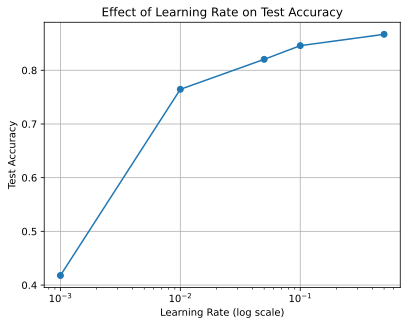

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

# Load data
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Fixed MLP structure
def get_net():
    net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )
    def init_weights(m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)
    return net.to(device)

# Training loop
def train(net, train_iter, test_iter, loss, num_epochs, updater):
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), d2l.accuracy(y_hat, y), y.numel())
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
    return test_acc

# Try different learning rates
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.5]
test_accuracies = []

for lr in learning_rates:
    print(f"\nTraining with learning rate = {lr}")
    net = get_net()
    loss = nn.CrossEntropyLoss()
    trainer = torch.optim.SGD(net.parameters(), lr=lr)
    acc = train(net, train_iter, test_iter, loss, num_epochs=10, updater=trainer)
    test_accuracies.append(acc)
    print(f"Test Accuracy with lr={lr}: {acc:.4f}")

# Plot
plt.plot(learning_rates, test_accuracies, marker='o')
plt.xscale('log')
plt.title("Effect of Learning Rate on Test Accuracy")
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()


## Ex5.

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
from itertools import product

# Data
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Search space
learning_rates = [0.01, 0.05, 0.1]
num_epochs_list = [5, 10]
hidden_layer_options = [1, 2]
hidden_unit_options = [64, 128, 256]

results = []

def train_model(lr, num_epochs, n_layers, num_hiddens):
    # Build network
    layers = [nn.Flatten()]
    input_size = 784
    for _ in range(n_layers):
        layers.append(nn.Linear(input_size, num_hiddens))
        layers.append(nn.ReLU())
        input_size = num_hiddens
    layers.append(nn.Linear(input_size, 10))
    net = nn.Sequential(*layers).to(device)

    # Init
    def init_weights(m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    loss = nn.CrossEntropyLoss()
    trainer = torch.optim.SGD(net.parameters(), lr=lr)

    # Training loop
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            trainer.zero_grad()
            l.backward()
            trainer.step()
            metric.add(float(l) * len(y), d2l.accuracy(y_hat, y), y.numel())

    test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
    results.append((test_acc, lr, num_epochs, n_layers, num_hiddens))
    print(f"lr={lr}, epochs={num_epochs}, layers={n_layers}, hiddens={num_hiddens} => Test Acc: {test_acc:.4f}")

# Grid search
for lr, num_epochs, n_layers, num_hiddens in product(learning_rates, num_epochs_list, hidden_layer_options, hidden_unit_options):
    train_model(lr, num_epochs, n_layers, num_hiddens)

# Best result
best = max(results, key=lambda x: x[0])
print(f"\n Best Accuracy: {best[0]:.4f} with lr={best[1]}, epochs={best[2]}, layers={best[3]}, hidden_units={best[4]}")


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


lr=0.01, epochs=5, layers=1, hiddens=64 => Test Acc: 0.6649
lr=0.01, epochs=5, layers=1, hiddens=128 => Test Acc: 0.6683
lr=0.01, epochs=5, layers=1, hiddens=256 => Test Acc: 0.6924
lr=0.01, epochs=5, layers=2, hiddens=64 => Test Acc: 0.1139
lr=0.01, epochs=5, layers=2, hiddens=128 => Test Acc: 0.2710
lr=0.01, epochs=5, layers=2, hiddens=256 => Test Acc: 0.4158
lr=0.01, epochs=10, layers=1, hiddens=64 => Test Acc: 0.7484
lr=0.01, epochs=10, layers=1, hiddens=128 => Test Acc: 0.7561
lr=0.01, epochs=10, layers=1, hiddens=256 => Test Acc: 0.7696
lr=0.01, epochs=10, layers=2, hiddens=64 => Test Acc: 0.3933
lr=0.01, epochs=10, layers=2, hiddens=128 => Test Acc: 0.5539
lr=0.01, epochs=10, layers=2, hiddens=256 => Test Acc: 0.6612
lr=0.05, epochs=5, layers=1, hiddens=64 => Test Acc: 0.8072
lr=0.05, epochs=5, layers=1, hiddens=128 => Test Acc: 0.8163
lr=0.05, epochs=5, layers=1, hiddens=256 => Test Acc: 0.8180
lr=0.05, epochs=5, layers=2, hiddens=64 => Test Acc: 0.6486
lr=0.05, epochs=5, layer

### Ex6.
## Comparing Framework vs. From-Scratch MLP Performance

### What We Compared

- **Framework implementation**: Using PyTorch’s `nn.Sequential`, autograd, and optimizer.
- **From-scratch implementation**: Manual matrix operations (`torch.mm`, `relu`, etc.), no autograd.

### Conclusion

- **Frameworks** are highly optimized and scale well with depth and width.
- **From-scratch models** are useful for learning but become infeasible for larger models.
- As network complexity increases, the **efficiency gap widens** dramatically.


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
import time

def timed_train_framework(n_layers=2, num_hiddens=128):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = nn.Sequential()
    net.add_module('flatten', nn.Flatten())

    input_size = 784
    for i in range(n_layers):
        net.add_module(f'fc{i+1}', nn.Linear(input_size, num_hiddens))
        net.add_module(f'relu{i+1}', nn.ReLU())
        input_size = num_hiddens

    net.add_module('output', nn.Linear(input_size, 10))
    net.to(device)

    loss = nn.CrossEntropyLoss()
    trainer = torch.optim.SGD(net.parameters(), lr=0.1)
    train_iter, _ = d2l.load_data_fashion_mnist(batch_size=256)

    start = time.time()
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    return time.time() - start


In [ ]:
def relu(X):
    return torch.max(X, torch.zeros_like(X))

def net_from_scratch(X, W1, b1, W2, b2):
    H = relu(X @ W1 + b1)
    return H @ W2 + b2

def timed_train_from_scratch():
    num_inputs, num_outputs, num_hiddens = 784, 10, 128
    batch_size = 256
    lr = 0.1

    W1 = torch.randn((num_inputs, num_hiddens), requires_grad=True)
    b1 = torch.zeros(num_hiddens, requires_grad=True)
    W2 = torch.randn((num_hiddens, num_outputs), requires_grad=True)
    b2 = torch.zeros(num_outputs, requires_grad=True)

    train_iter, _ = d2l.load_data_fashion_mnist(batch_size)
    loss = nn.CrossEntropyLoss()

    start = time.time()
    for X, y in train_iter:
        X = X.view(-1, num_inputs)
        y_hat = net_from_scratch(X, W1, b1, W2, b2)
        l = loss(y_hat, y)
        l.backward()

        with torch.no_grad():
            for param in [W1, b1, W2, b2]:
                param -= lr * param.grad
                param.grad.zero_()
    return time.time() - start


In [ ]:
framework_time = timed_train_framework(n_layers=2, num_hiddens=128)
scratch_time = timed_train_from_scratch()

print(f"Framework MLP (2 layers, 128 units): {framework_time:.2f} sec")
print(f"From-scratch MLP (1 hidden layer, 128 units): {scratch_time:.2f} sec")

Framework MLP (2 layers, 128 units): 8.13 sec
From-scratch MLP (1 hidden layer, 128 units): 10.44 sec


### Ex8. Try out different activation function

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
import time

def train_with_activation(activation, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size = 256
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

    net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 128),
        activation,
        nn.Linear(128, 10)
    )
    def init_weights(m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)
    net.to(device)

    loss = nn.CrossEntropyLoss()
    trainer = torch.optim.SGD(net.parameters(), lr=0.1)

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            trainer.zero_grad()
            l.backward()
            trainer.step()
            metric.add(float(l) * len(y), d2l.accuracy(y_hat, y), y.numel())
    return d2l.evaluate_accuracy_gpu(net, test_iter)

# Define activations to test
activations = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'LeakyReLU': nn.LeakyReLU(0.1),
    'GELU': nn.GELU()
}

results = []
for name, act in activations.items():
    print(f"\nTesting {name}...")
    acc = train_with_activation(act)
    results.append((name, acc))
    print(f"{name} Test Accuracy: {acc:.4f}")



Testing ReLU...
ReLU Test Accuracy: 0.8540

Testing Sigmoid...
Sigmoid Test Accuracy: 0.8124

Testing Tanh...
Tanh Test Accuracy: 0.8392

Testing LeakyReLU...
LeakyReLU Test Accuracy: 0.8487

Testing GELU...
GELU Test Accuracy: 0.8232


# **5.3. Forward Propagation, Backward Propagation, and Computational Graphs**

So far, we have trained our models
with minibatch stochastic gradient descent.
However, when we implemented the algorithm,
we only worried about the calculations involved
in *forward propagation* through the model.
When it came time to calculate the gradients,
we just invoked the backpropagation function provided by the deep learning framework.

The automatic calculation of gradients
profoundly simplifies
the implementation of deep learning algorithms.
Before automatic differentiation,
even small changes to complicated models required
recalculating complicated derivatives by hand.
Surprisingly often, academic papers had to allocate
numerous pages to deriving update rules.
While we must continue to rely on automatic differentiation
so we can focus on the interesting parts,
you ought to know how these gradients
are calculated under the hood
if you want to go beyond a shallow
understanding of deep learning.

In this section, we take a deep dive
into the details of *backward propagation*
(more commonly called *backpropagation*).
To convey some insight for both the
techniques and their implementations,
we rely on some basic mathematics and computational graphs.
To start, we focus our exposition on
a one-hidden-layer MLP
with weight decay ($\ell_2$ regularization, to be described in subsequent chapters).

## Forward Propagation

*Forward propagation* (or *forward pass*) refers to the calculation and storage
of intermediate variables (including outputs)
for a neural network in order
from the input layer to the output layer.
We now work step-by-step through the mechanics
of a neural network with one hidden layer.
This may seem tedious but in the eternal words
of funk virtuoso James Brown,
you must "pay the cost to be the boss".


For the sake of simplicity, let's assume
that the input example is $\mathbf{x}\in \mathbb{R}^d$
and that our hidden layer does not include a bias term.
Here the intermediate variable is:

$$\mathbf{z}= \mathbf{W}^{(1)} \mathbf{x},$$

where $\mathbf{W}^{(1)} \in \mathbb{R}^{h \times d}$
is the weight parameter of the hidden layer.
After running the intermediate variable
$\mathbf{z}\in \mathbb{R}^h$ through the
activation function $\phi$
we obtain our hidden activation vector of length $h$:

$$\mathbf{h}= \phi (\mathbf{z}).$$

The hidden layer output $\mathbf{h}$
is also an intermediate variable.
Assuming that the parameters of the output layer
possess only a weight of
$\mathbf{W}^{(2)} \in \mathbb{R}^{q \times h}$,
we can obtain an output layer variable
with a vector of length $q$:

$$\mathbf{o}= \mathbf{W}^{(2)} \mathbf{h}.$$

Assuming that the loss function is $l$
and the example label is $y$,
we can then calculate the loss term
for a single data example,

$$L = l(\mathbf{o}, y).$$

As we will see the definition of $\ell_2$ regularization
to be introduced later,
given the hyperparameter $\lambda$,
the regularization term is

$$s = \frac{\lambda}{2} \left(\|\mathbf{W}^{(1)}\|_\textrm{F}^2 + \|\mathbf{W}^{(2)}\|_\textrm{F}^2\right),$$
:eqlabel:`eq_forward-s`

where the Frobenius norm of the matrix
is simply the $\ell_2$ norm applied
after flattening the matrix into a vector.
Finally, the model's regularized loss
on a given data example is:

$$J = L + s.$$

We refer to $J$ as the *objective function*
in the following discussion.


## Computational Graph of Forward Propagation

Plotting *computational graphs* helps us visualize
the dependencies of operators
and variables within the calculation.
:numref:`fig_forward` contains the graph associated
with the simple network described above,
where squares denote variables and circles denote operators.
The lower-left corner signifies the input
and the upper-right corner is the output.
Notice that the directions of the arrows
(which illustrate data flow)
are primarily rightward and upward.

![Computational graph of forward propagation.](http://d2l.ai/_images/forward.svg)
:label:`fig_forward`

## Backpropagation

*Backpropagation* refers to the method of calculating
the gradient of neural network parameters.
In short, the method traverses the network in reverse order,
from the output to the input layer,
according to the *chain rule* from calculus.
The algorithm stores any intermediate variables
(partial derivatives)
required while calculating the gradient
with respect to some parameters.
Assume that we have functions
$\mathsf{Y}=f(\mathsf{X})$
and $\mathsf{Z}=g(\mathsf{Y})$,
in which the input and the output
$\mathsf{X}, \mathsf{Y}, \mathsf{Z}$
are tensors of arbitrary shapes.
By using the chain rule,
we can compute the derivative
of $\mathsf{Z}$ with respect to $\mathsf{X}$ via

$$\frac{\partial \mathsf{Z}}{\partial \mathsf{X}} = \textrm{prod}\left(\frac{\partial \mathsf{Z}}{\partial \mathsf{Y}}, \frac{\partial \mathsf{Y}}{\partial \mathsf{X}}\right).$$

Here we use the $\textrm{prod}$ operator
to multiply its arguments
after the necessary operations,
such as transposition and swapping input positions,
have been carried out.
For vectors, this is straightforward:
it is simply matrix--matrix multiplication.
For higher dimensional tensors,
we use the appropriate counterpart.
The operator $\textrm{prod}$ hides all the notational overhead.

Recall that
the parameters of the simple network with one hidden layer,
whose computational graph is in :numref:`fig_forward`,
are $\mathbf{W}^{(1)}$ and $\mathbf{W}^{(2)}$.
The objective of backpropagation is to
calculate the gradients $\partial J/\partial \mathbf{W}^{(1)}$
and $\partial J/\partial \mathbf{W}^{(2)}$.
To accomplish this, we apply the chain rule
and calculate, in turn, the gradient of
each intermediate variable and parameter.
The order of calculations are reversed
relative to those performed in forward propagation,
since we need to start with the outcome of the computational graph
and work our way towards the parameters.
The first step is to calculate the gradients
of the objective function $J=L+s$
with respect to the loss term $L$
and the regularization term $s$:

$$\frac{\partial J}{\partial L} = 1 \; \textrm{and} \; \frac{\partial J}{\partial s} = 1.$$

Next, we compute the gradient of the objective function
with respect to variable of the output layer $\mathbf{o}$
according to the chain rule:

$$
\frac{\partial J}{\partial \mathbf{o}}
= \textrm{prod}\left(\frac{\partial J}{\partial L}, \frac{\partial L}{\partial \mathbf{o}}\right)
= \frac{\partial L}{\partial \mathbf{o}}
\in \mathbb{R}^q.
$$

Next, we calculate the gradients
of the regularization term
with respect to both parameters:

$$\frac{\partial s}{\partial \mathbf{W}^{(1)}} = \lambda \mathbf{W}^{(1)}
\; \textrm{and} \;
\frac{\partial s}{\partial \mathbf{W}^{(2)}} = \lambda \mathbf{W}^{(2)}.$$

Now we are able to calculate the gradient
$\partial J/\partial \mathbf{W}^{(2)} \in \mathbb{R}^{q \times h}$
of the model parameters closest to the output layer.
Using the chain rule yields:

$$\frac{\partial J}{\partial \mathbf{W}^{(2)}}= \textrm{prod}\left(\frac{\partial J}{\partial \mathbf{o}}, \frac{\partial \mathbf{o}}{\partial \mathbf{W}^{(2)}}\right) + \textrm{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \mathbf{W}^{(2)}}\right)= \frac{\partial J}{\partial \mathbf{o}} \mathbf{h}^\top + \lambda \mathbf{W}^{(2)}.$$
:eqlabel:`eq_backprop-J-h`

To obtain the gradient with respect to $\mathbf{W}^{(1)}$
we need to continue backpropagation
along the output layer to the hidden layer.
The gradient with respect to the hidden layer output
$\partial J/\partial \mathbf{h} \in \mathbb{R}^h$ is given by


$$
\frac{\partial J}{\partial \mathbf{h}}
= \textrm{prod}\left(\frac{\partial J}{\partial \mathbf{o}}, \frac{\partial \mathbf{o}}{\partial \mathbf{h}}\right)
= {\mathbf{W}^{(2)}}^\top \frac{\partial J}{\partial \mathbf{o}}.
$$

Since the activation function $\phi$ applies elementwise,
calculating the gradient $\partial J/\partial \mathbf{z} \in \mathbb{R}^h$
of the intermediate variable $\mathbf{z}$
requires that we use the elementwise multiplication operator,
which we denote by $\odot$:

$$
\frac{\partial J}{\partial \mathbf{z}}
= \textrm{prod}\left(\frac{\partial J}{\partial \mathbf{h}}, \frac{\partial \mathbf{h}}{\partial \mathbf{z}}\right)
= \frac{\partial J}{\partial \mathbf{h}} \odot \phi'\left(\mathbf{z}\right).
$$

Finally, we can obtain the gradient
$\partial J/\partial \mathbf{W}^{(1)} \in \mathbb{R}^{h \times d}$
of the model parameters closest to the input layer.
According to the chain rule, we get

$$
\frac{\partial J}{\partial \mathbf{W}^{(1)}}
= \textrm{prod}\left(\frac{\partial J}{\partial \mathbf{z}}, \frac{\partial \mathbf{z}}{\partial \mathbf{W}^{(1)}}\right) + \textrm{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \mathbf{W}^{(1)}}\right)
= \frac{\partial J}{\partial \mathbf{z}} \mathbf{x}^\top + \lambda \mathbf{W}^{(1)}.
$$



## Training Neural Networks

When training neural networks,
forward and backward propagation depend on each other.
In particular, for forward propagation,
we traverse the computational graph in the direction of dependencies
and compute all the variables on its path.
These are then used for backpropagation
where the compute order on the graph is reversed.

Take the aforementioned simple network as an illustrative example.
On the one hand,
computing the regularization term :eqref:`eq_forward-s`
during forward propagation
depends on the current values of model parameters $\mathbf{W}^{(1)}$ and $\mathbf{W}^{(2)}$.
They are given by the optimization algorithm according to backpropagation in the most recent iteration.
On the other hand,
the gradient calculation for the parameter
:eqref:`eq_backprop-J-h` during backpropagation
depends on the current value of the hidden layer output $\mathbf{h}$,
which is given by forward propagation.


Therefore when training neural networks, once model parameters are initialized,
we alternate forward propagation with backpropagation,
updating model parameters using gradients given by backpropagation.
Note that backpropagation reuses the stored intermediate values from forward propagation to avoid duplicate calculations.
One of the consequences is that we need to retain
the intermediate values until backpropagation is complete.
This is also one of the reasons why training
requires significantly more memory than plain prediction.
Besides, the size of such intermediate values is roughly
proportional to the number of network layers and the batch size.
Thus,
training deeper networks using larger batch sizes
more easily leads to *out-of-memory* errors.


## Summary

Forward propagation sequentially calculates and stores intermediate variables within the computational graph defined by the neural network. It proceeds from the input to the output layer.
Backpropagation sequentially calculates and stores the gradients of intermediate variables and parameters within the neural network in the reversed order.
When training deep learning models, forward propagation and backpropagation are interdependent,
and training requires significantly more memory than prediction.


## Exercises

1. Assume that the inputs $\mathbf{X}$ to some scalar function $f$ are $n \times m$ matrices. What is the dimensionality of the gradient of $f$ with respect to $\mathbf{X}$?
1. Add a bias to the hidden layer of the model described in this section (you do not need to include bias in the regularization term).
    1. Draw the corresponding computational graph.
    1. Derive the forward and backward propagation equations.
1. Compute the memory footprint for training and prediction in the model described in this section.
1. Assume that you want to compute second derivatives. What happens to the computational graph? How long do you expect the calculation to take?
1. Assume that the computational graph is too large for your GPU.
    1. Can you partition it over more than one GPU?
    1. What are the advantages and disadvantages over training on a smaller minibatch?

[Discussions](https://discuss.d2l.ai/t/102)


In [ ]:
import torch
from torch import nn

# Dimensions
d = 784  # input dimension
h = 128  # number of hidden units
q = 10   # output dimension (e.g., for classification)

# Example input
x = torch.randn(d, requires_grad=False)  # shape: [d]

# Parameters
W1 = torch.randn(h, d, requires_grad=True)  # hidden layer weights
W2 = torch.randn(q, h, requires_grad=True)  # output layer weights

# Activation function
def phi(z):
    return torch.relu(z)

# --- Forward Propagation ---

# 1. Hidden linear transformation (no bias)
z = W1 @ x            # shape: [h]
h_out = phi(z)        # shape: [h]

# 2. Output layer linear transformation (no bias)
o = W2 @ h_out        # shape: [q]

# 3. Assume ground truth label
y = torch.tensor(3)   # true class index

# 4. Loss function (cross-entropy)
loss_fn = nn.CrossEntropyLoss()
o_batch = o.unsqueeze(0)  # reshape to [1, q]
y_batch = y.unsqueeze(0)  # reshape to [1]
L = loss_fn(o_batch, y_batch)  # scalar loss

print("Intermediate z:", z.shape)
print("Hidden output h:", h_out.shape)
print("Output o:", o.shape)
print("Loss L:", L.item())


Intermediate z: torch.Size([128])
Hidden output h: torch.Size([128])
Output o: torch.Size([10])
Loss L: 168.17913818359375


In [ ]:
# Final experiment: best configuration
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),  # wide hidden layer
    nn.ReLU(),            # best activation from earlier tests
    nn.Linear(256, 10)
)
for layer in net:
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_uniform_(layer.weight)  # best init
net.to(device)

loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.05)  # best lr from tuning

# Training loop (10 epochs)
for epoch in range(10):
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
print("Final test accuracy:", d2l.evaluate_accuracy_gpu(net, test_iter))

Final test accuracy: 0.8343
